In [10]:
# TensorFlow & keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Input, BatchNormalization

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# function to plot models loss/accuracy results

def plot_results(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'],':r')
    plt.plot(history.history['val_loss'],'.-r')
    plt.title('Loss',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'],':b')
    plt.plot(history.history['val_accuracy'],'b')
    plt.ylim([0, 1])
    plt.title('Accuracy',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
    plt.grid()

Found 6000 images belonging to 6 classes.
Found 6000 images belonging to 6 classes.
imgs array size:  (6000, 150, 150, 3) 
labels array size: (6000,)


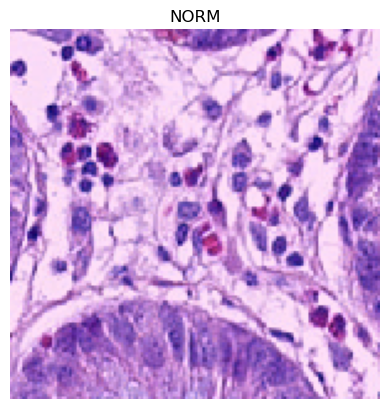

train ds and labels sizes: (5400, 150, 150, 3) (5400,) 
test ds and labels sizes: (600, 150, 150, 3) (600,)


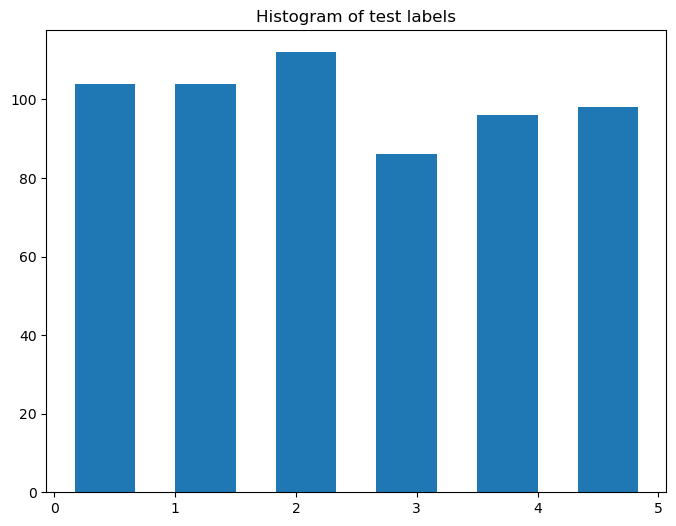

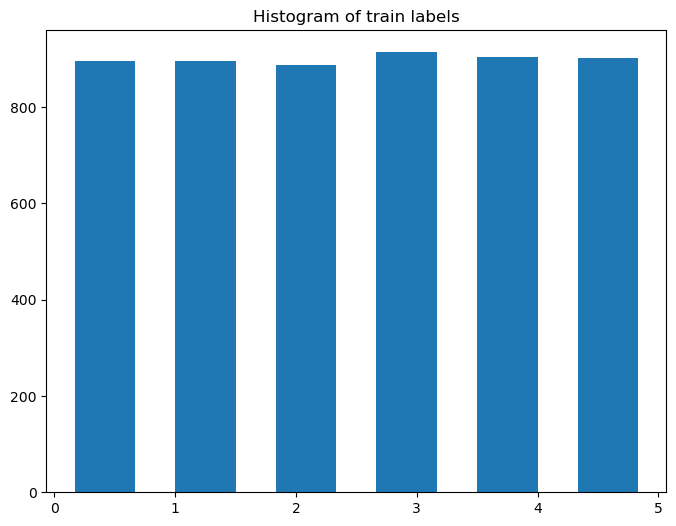

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Set the path to the dataset folder relative to your notebook file
train_data_dir = './Demo_Dataset(reinhard+flip)'

# Get class names excluding '.ipynb_checkpoints'
classes = [d for d in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir, d)) and d != '.ipynb_checkpoints']

# Use ImageDataGenerator to load and normalize data
datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0,1]

# Generate the training set with the corrected classes list
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),  # Target image size
    batch_size=datagen.flow_from_directory(train_data_dir, classes=classes).samples,  # Set to load the entire dataset
    class_mode='sparse',  # Labels as integers (no need for one-hot encoding)
    shuffle=True,
    classes=classes  # Explicitly specify classes to exclude .ipynb_checkpoints
)

# Load all images and labels using the next() function
X, y = next(train_generator)

# Print the size of images and labels
print('imgs array size: ', X.shape, '\nlabels array size:', y.shape)

# Define class names
class_names = list(train_generator.class_indices.keys())

# Display an image
num = 8  # Select the image number to display
plt.imshow(X[num])
plt.axis('off')
plt.title(class_names[int(y[num])])
plt.show()

# Split dataset into 90% training set and 10% test set
total_size = X.shape[0]
train_size = int(0.9 * total_size)
test_size = total_size - train_size

# Split into training and test sets
train_images = X[:train_size]
train_labels = y[:train_size]

test_images = X[train_size:]
test_labels = y[train_size:]

# Print sizes of the training and test sets
print('train ds and labels sizes:', train_images.shape, train_labels.shape,
      '\ntest ds and labels sizes:', test_images.shape, test_labels.shape)

# Convert labels to one-hot encoding
train_labels_onehot = tf.one_hot(train_labels.astype(int), depth=len(class_names))
test_labels_onehot = tf.one_hot(test_labels.astype(int), depth=len(class_names))

# Display a histogram of the test labels
plt.figure(figsize=(8, 6))
plt.hist(test_labels, bins=len(class_names), rwidth=0.6, align='mid')
plt.title('Histogram of test labels')
plt.show()

# Display a histogram of the training labels
plt.figure(figsize=(8, 6))
plt.hist(train_labels, bins=len(class_names), rwidth=0.6, align='mid')
plt.title('Histogram of train labels')
plt.show()


In [4]:
# VGG 16 Transfer learning
#We will use the VGG16 model, but we need to change its top layers to be able to feed images of different size to its network. we need to change the output of the convolutional stack accordingly to our data. In this way, we can apply the VGG16 architecture to images of our size.

#paste our own densely connected classifier on top of it: 256 dense layer -> dropout 0.5 -> 6 dense softmax output

#freezing the first layer of the network to prevent the weights in this layer from being updated during training.

In [13]:
# VGG MODEL WITH NEW TOP

model = Sequential()
vgg16 = tf.keras.applications.VGG16(input_shape=(150,150,3), include_top=False) # VGG16 no top
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu')) # adding 256 dense layer
model.add(Dropout(0.5)) # adding dropout
model.add(Dense(6, activation='softmax')) # softmax output

model.layers[0].trainable = False # freezing first layer

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,813,638 (64.14 MB)

 Trainable params: 2,098,950 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
# VGG LIKE MODEL WITH RMSPROP OPT

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels_onehot, epochs=10, batch_size=32, verbose=1,
                    validation_data=(test_images, test_labels_onehot))

Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 138s 814ms/step - accuracy: 0.5685 - loss: 1.6588 - val_accuracy: 0.7933 - val_loss: 0.5734
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 141s 836ms/step - accuracy: 0.7759 - loss: 0.6333 - val_accuracy: 0.8183 - val_loss: 0.5441
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 142s 841ms/step - accuracy: 0.8138 - loss: 0.5276 - val_accuracy: 0.8100 - val_loss: 0.5277
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 141s 837ms/step - accuracy: 0.8358 - loss: 0.4774 - val_accuracy: 0.8267 - val_loss: 0.4869
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 138s 820ms/step - accuracy: 0.8588 - loss: 0.4165 - val_accuracy: 0.8533 - val_loss: 0.4548
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 147s 873ms/step - accuracy: 0.8691 - loss: 0.3752 - val_accuracy: 0.8700 - val_loss: 0.4234
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 148s 877ms/step - accuracy: 0.8795 - loss: 0.3533 - val_accuracy: 0.8700 - val_loss: 0.4139
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 152s 897ms/step - accuracy: 0.8943 -

Train accuracy =  0.8996296525001526
Test accuracy =  0.8666666746139526




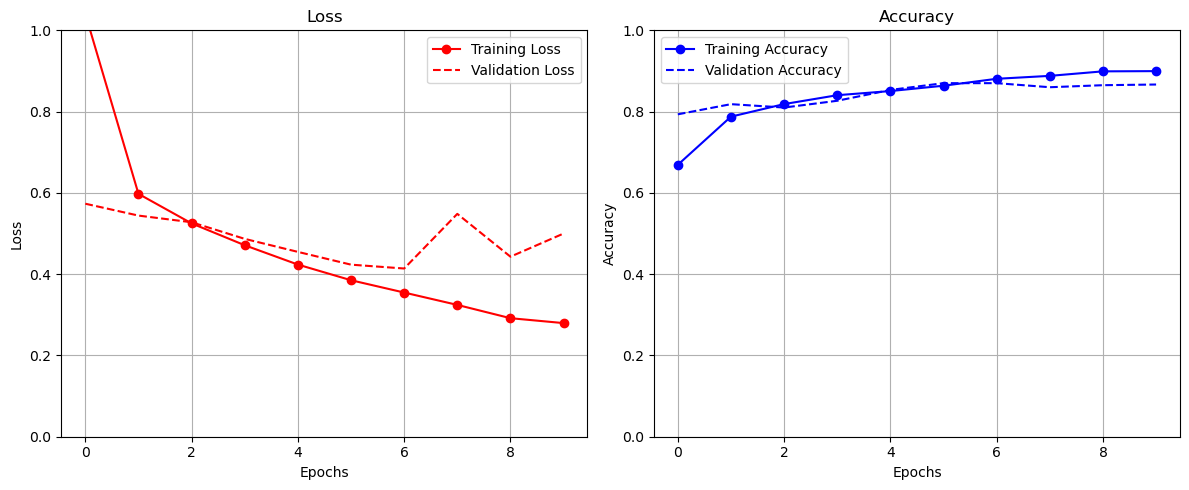

In [15]:
import matplotlib.pyplot as plt

def plot_results(history):
    # Set consistent y-axis limits
    loss_ylim = [0, 1]  # Set y-axis range for loss
    acc_ylim = [0, 1]   # Set y-axis range for accuracy

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'ro-', label='Training Loss')
    plt.plot(history.history['val_loss'], 'r--', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(loss_ylim)  # Keep the y-axis range fixed
    plt.legend()  # Add legend
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], 'b--', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(acc_ylim)  # Keep the y-axis range fixed
    plt.legend()  # Add legend
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage with history object
print('Train accuracy = ', history.history['accuracy'][-1])
print('Test accuracy = ', history.history['val_accuracy'][-1])
print('\n')

# Call the function to plot results with legend
plot_results(history)


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 516ms/step
[[101   1   0   1   1   0]
 [  1  79   8   5   7   4]
 [  0   7 103   0   1   1]
 [  3   1   2  74   1   5]
 [  0   2   3   0  87   4]
 [  0   2   3   2  15  76]]


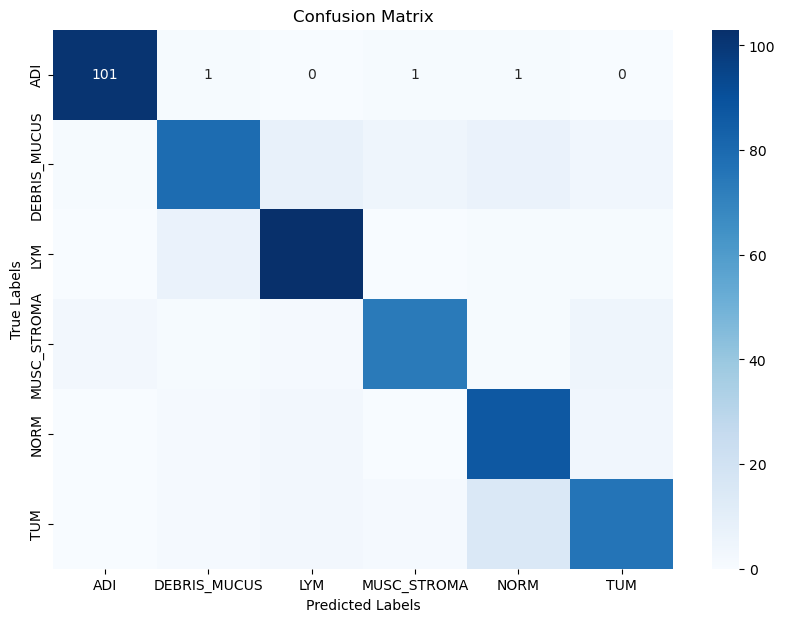

In [16]:
# confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_images)
matrix = confusion_matrix(test_labels, y_pred.argmax(axis=1)) # confusion matrix
print(matrix)
# Plotting
plt.figure(figsize=(10, 7))  # Adjust the size of the figure as needed
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
#ROC 结果存疑，后续需要排除

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 490ms/step


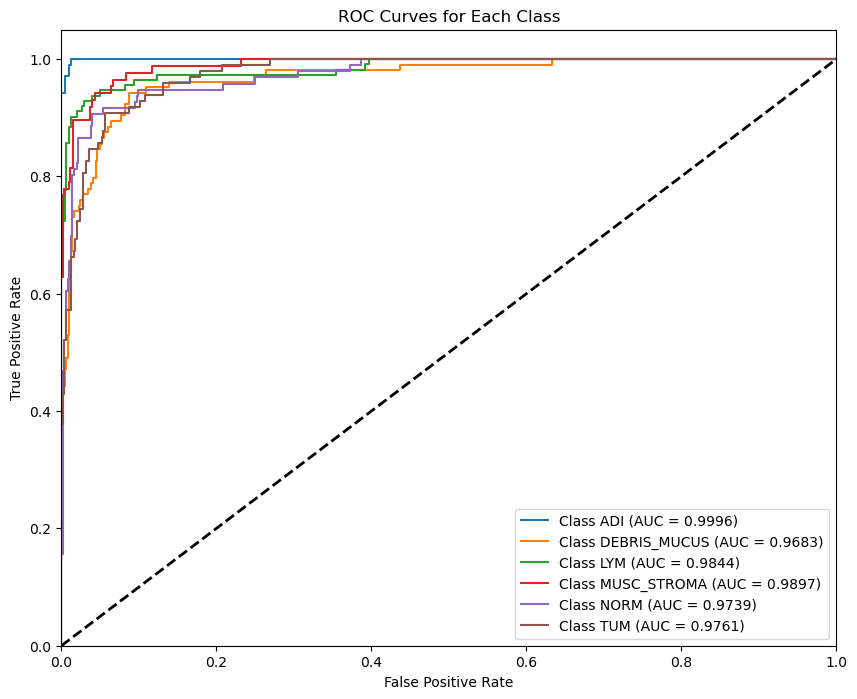

In [18]:
#ROC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# 假设 test_labels_onehot 是 one-hot 编码的真实标签，模型预测的结果是 y_pred

# 模型对测试集的预测结果
y_pred = model.predict(test_images)

# 将标签二值化，方便计算每个类别的 ROC 曲线
n_classes = len(class_names)  # 类别数量
test_labels_binarized = label_binarize(test_labels, classes=[i for i in range(n_classes)])

# 初始化绘图
plt.figure(figsize=(10, 8))

# 为每个类别计算并绘制 ROC 曲线
for i in range(n_classes):
    # 计算 ROC 曲线
    fpr, tpr, _ = roc_curve(test_labels_binarized[:, i], y_pred[:, i])
    
    # 计算 AUC
    roc_auc = auc(fpr, tpr)
    
    # 绘制 ROC 曲线
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.4f})')

# 绘制对角线：代表随机分类的基线
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# 设置图像标题和标签
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()
